# Recognition

This notebook is based on the tutorial provided by Roboflow at https://blog.roboflow.com/training-a-tensorflow-object-detection-model-with-a-custom-dataset/

It was slightly modified for our own dataset provided by the University of Grenada for public use at https://public.roboflow.com/object-detection/pistols

The method employed here the TensorFlow supported training model Single Snapshot Detector - MobileNetv2

## Configs and Hyperparameters

Support a variety of models, you can find more pretrained model from [Tensorflow detection model zoo: COCO-trained models](https://github.com/tensorflow/models/blob/master/research/object_detection/g3doc/detection_model_zoo.md#coco-trained-models), as well as their pipline config files in [object_detection/samples/configs/](https://github.com/tensorflow/models/tree/master/research/object_detection/samples/configs).

In [37]:
# If you forked the repo, you can replace the link.
repo_url = 'https://github.com/roboflow-ai/tensorflow-object-detection-faster-rcnn'

# Number of training steps - 1000 will train very quickly, but more steps will increase accuracy.
num_steps = 20000  # 200000 to improve

# Number of evaluation steps.
num_eval_steps = 10

MODELS_CONFIG = {
    'ssd_mobilenet_v2': {
        'model_name': 'ssd_mobilenet_v2_coco_2018_03_29',
        'pipeline_file': 'ssd_mobilenet_v2_coco.config',
        'batch_size': 12
    },
    'faster_rcnn_inception_v2': {
        'model_name': 'faster_rcnn_inception_v2_coco_2018_01_28',
        'pipeline_file': 'faster_rcnn_inception_v2_pets.config',
        'batch_size': 12
    },
    'rfcn_resnet101': {
        'model_name': 'rfcn_resnet101_coco_2018_01_28',
        'pipeline_file': 'rfcn_resnet101_pets.config',
        'batch_size': 8
    },    
}

# Pick the model you want to use
# Select a model in `MODELS_CONFIG`.
selected_model = 'ssd_mobilenet_v2'

# Name of the object detection model to use.
MODEL = MODELS_CONFIG[selected_model]['model_name']

# Name of the pipline file in tensorflow object detection API.
pipeline_file = MODELS_CONFIG[selected_model]['pipeline_file']

# Training batch size fits in Colabe's Tesla K80 GPU memory for selected model.
batch_size = MODELS_CONFIG[selected_model]['batch_size']

In [38]:
# use TF 1.x for Object Detection APIs as they are not ported to TF 2.0 yet
%tensorflow_version 1.x

## Clone the `tensorflow-object-detection` repository or your fork.

In [39]:
import os

%cd /content

repo_dir_path = os.path.abspath(os.path.join('.', os.path.basename(repo_url)))

!git clone {repo_url}
%cd {repo_dir_path}
!git pull

/content
fatal: destination path 'tensorflow-object-detection-faster-rcnn' already exists and is not an empty directory.
/content/tensorflow-object-detection-faster-rcnn
Already up to date.


## Install required packages

In [40]:
%cd /content
!git clone --quiet https://github.com/tensorflow/models.git

!pip install tf_slim

!apt-get install -qq protobuf-compiler python-pil python-lxml python-tk

!pip install -q Cython contextlib2 pillow lxml matplotlib

!pip install -q pycocotools

!pip install lvis

%cd /content/models/research
!protoc object_detection/protos/*.proto --python_out=.

import os
os.environ['PYTHONPATH'] += ':/content/models/research/:/content/models/research/slim/'

!pip install numpy==1.19.5
!pip uninstall -y pycocotools
!pip install pycocotools --no-binary pycocotools

!python object_detection/builders/model_builder_test.py

/content
fatal: destination path 'models' already exists and is not an empty directory.
/content/models/research
Found existing installation: pycocotools 2.0.4
Uninstalling pycocotools-2.0.4:
  Successfully uninstalled pycocotools-2.0.4
  Using cached pycocotools-2.0.4.tar.gz (106 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
  Created wheel for pycocotools: filename=pycocotools-2.0.4-cp37-cp37m-linux_x86_64.whl size=265201 sha256=3ccae576a0fd16ad07645caeb5b66d3706872319c8f44266364c4c1f2274eb92
  Stored in directory: /root/.cache/pip/wheels/a3/5f/fa/f011e578cc76e1fc5be8dce30b3eb9fd00f337e744b3bba59b
Successfully built pycocotools
Using TensorFlow backend.


## Prepare `tfrecord` files

Roboflow automatically creates our TFRecord and label_map files that we need!

Because we need one TFRecord file for our training data, and one TFRecord file for our test data, we'll create two separate datasets in Roboflow and generate one set of TFRecords for each.

In [41]:
%cd /content/tensorflow-object-detection-faster-rcnn/data

/content/tensorflow-object-detection-faster-rcnn/data


In [42]:
!curl -L "https://app.roboflow.com/ds/RDuTGkMfJF?key=BPa6gmTGL7" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   883  100   883    0     0   1656      0 --:--:-- --:--:-- --:--:--  1656
100 58.2M  100 58.2M    0     0  30.5M      0  0:00:01  0:00:01 --:--:-- 62.2M
Archive:  roboflow.zip
replace README.dataset.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [46]:
# training set
%ls train

weapons_label_map.pbtxt  weapons.tfrecord


In [47]:
# test set
%ls test

weapons_label_map.pbtxt  weapons.tfrecord


In [48]:
# NOTE: Update these TFRecord names from "cells" and "cells_label_map" to your files!
test_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/test/weapons.tfrecord'
train_record_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/weapons.tfrecord'
label_map_pbtxt_fname = '/content/tensorflow-object-detection-faster-rcnn/data/train/weapons_label_map.pbtxt'

## Download base model

In [50]:
%cd /content/models/research

import os
import shutil
import glob
import urllib.request
import tarfile
MODEL_FILE = MODEL + '.tar.gz'
DOWNLOAD_BASE = 'http://download.tensorflow.org/models/object_detection/'
DEST_DIR = '/content/models/research/pretrained_model'

if not (os.path.exists(MODEL_FILE)):
    urllib.request.urlretrieve(DOWNLOAD_BASE + MODEL_FILE, MODEL_FILE)

tar = tarfile.open(MODEL_FILE)
tar.extractall()
tar.close()

os.remove(MODEL_FILE)
if (os.path.exists(DEST_DIR)):
    shutil.rmtree(DEST_DIR)
os.rename(MODEL, DEST_DIR)

/content/models/research


In [51]:
!echo {DEST_DIR}
!ls -alh {DEST_DIR}

/content/models/research/pretrained_model
total 135M
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 .
drwxr-xr-x 25 root   root  4.0K Apr 29 04:25 ..
-rw-r--r--  1 345018 89939   77 Mar 30  2018 checkpoint
-rw-r--r--  1 345018 89939  67M Mar 30  2018 frozen_inference_graph.pb
-rw-r--r--  1 345018 89939  65M Mar 30  2018 model.ckpt.data-00000-of-00001
-rw-r--r--  1 345018 89939  15K Mar 30  2018 model.ckpt.index
-rw-r--r--  1 345018 89939 3.4M Mar 30  2018 model.ckpt.meta
-rw-r--r--  1 345018 89939 4.2K Mar 30  2018 pipeline.config
drwxr-xr-x  3 345018 89939 4.0K Mar 30  2018 saved_model


In [52]:
fine_tune_checkpoint = os.path.join(DEST_DIR, "model.ckpt")
fine_tune_checkpoint

'/content/models/research/pretrained_model/model.ckpt'

## Configuring a Training Pipeline

In [53]:
import os
pipeline_fname = os.path.join('/content/models/research/object_detection/samples/configs/', pipeline_file)

assert os.path.isfile(pipeline_fname), '`{}` not exist'.format(pipeline_fname)

In [54]:
def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

In [55]:
import re

num_classes = get_num_classes(label_map_pbtxt_fname)
with open(pipeline_fname) as f:
    s = f.read()
with open(pipeline_fname, 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(train.record)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(val.record)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    f.write(s)

In [56]:
!cat {pipeline_fname}

# SSD with Mobilenet v2 configuration for MSCOCO Dataset.
# Users should configure the fine_tune_checkpoint field in the train config as
# well as the label_map_path and input_path fields in the train_input_reader and
# eval_input_reader. Search for "PATH_TO_BE_CONFIGURED" to find the fields that
# should be configured.

model {
  ssd {
    num_classes: 1
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    anchor_generator {
      ssd_anchor_generator {
        num_layers: 6
        min_scale: 0.2
        max_scale: 0.95
        aspect_ratios: 1.0
        aspect_ratios: 2.0
        aspect_

In [57]:
model_dir = 'training/'
# Optionally remove content in output model directory to fresh start.
!rm -rf {model_dir}
os.makedirs(model_dir, exist_ok=True)

## Train the model

In [58]:
!python /content/models/research/object_detection/model_main.py \
    --pipeline_config_path={pipeline_fname} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps={num_steps} \
    --num_eval_steps={num_eval_steps}

Using TensorFlow backend.
W0429 04:28:45.530563 139634347370368 model_lib.py:839] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting train_steps: 20000
I0429 04:28:45.530744 139634347370368 config_util.py:552] Maybe overwriting train_steps: 20000
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0429 04:28:45.530809 139634347370368 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: 1
I0429 04:28:45.530862 139634347370368 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: 1
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0429 04:28:45.530915 139634347370368 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0429 04:28:45.530984 139634347370368 model_lib.py:855] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
INFO:tensorflow:create_estimator_and_inputs

In [59]:
!ls {model_dir}

checkpoint
eval_0
events.out.tfevents.1651206539.4bc34ec62da5
export
graph.pbtxt
model.ckpt-13121.data-00000-of-00001
model.ckpt-13121.index
model.ckpt-13121.meta
model.ckpt-16388.data-00000-of-00001
model.ckpt-16388.index
model.ckpt-16388.meta
model.ckpt-19650.data-00000-of-00001
model.ckpt-19650.index
model.ckpt-19650.meta
model.ckpt-20000.data-00000-of-00001
model.ckpt-20000.index
model.ckpt-20000.meta
model.ckpt-9842.data-00000-of-00001
model.ckpt-9842.index
model.ckpt-9842.meta


## Exporting a Trained Inference Graph
Once your training job is complete, you need to extract the newly trained inference graph, which will be later used to perform the object detection. This can be done as follows:

In [60]:
import re
import numpy as np

output_directory = './fine_tuned_model'

lst = os.listdir(model_dir)
lst = [l for l in lst if 'model.ckpt-' in l and '.meta' in l]
steps=np.array([int(re.findall('\d+', l)[0]) for l in lst])
last_model = lst[steps.argmax()].replace('.meta', '')

last_model_path = os.path.join(model_dir, last_model)
print(last_model_path)
!python /content/models/research/object_detection/export_inference_graph.py \
    --input_type=image_tensor \
    --pipeline_config_path={pipeline_fname} \
    --output_directory={output_directory} \
    --trained_checkpoint_prefix={last_model_path}

training/model.ckpt-20000
Using TensorFlow backend.
Instructions for updating:
Please use `layer.__call__` method instead.
W0429 05:32:37.333354 140051418019712 deprecation.py:323] From /usr/local/lib/python3.7/dist-packages/tf_slim/layers/layers.py:1089: Layer.apply (from tensorflow.python.keras.engine.base_layer) is deprecated and will be removed in a future version.
Instructions for updating:
Please use `layer.__call__` method instead.
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 05:32:39.200979 140051418019712 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 05:32:39.236406 140051418019712 convolutional_box_predictor.py:155] depth of additional conv before box predictor: 0
INFO:tensorflow:depth of additional conv before box predictor: 0
I0429 05:32:39.269397 140051418019712 convolutional_box_predictor.py:155] depth of additional conv before box predic

In [61]:
!ls {output_directory}

checkpoint			model.ckpt.index  saved_model
frozen_inference_graph.pb	model.ckpt.meta
model.ckpt.data-00000-of-00001	pipeline.config


## Download the model `.pb` file

In [62]:
import os

pb_fname = os.path.join(os.path.abspath(output_directory), "frozen_inference_graph.pb")
assert os.path.isfile(pb_fname), '`{}` not exist'.format(pb_fname)

In [64]:
!ls -alh {pb_fname}

-rw-r--r-- 1 root root 19M Apr 29 05:32 /content/models/research/fine_tuned_model/frozen_inference_graph.pb


### Option1 : upload the `.pb` file to your Google Drive
Then download it from your Google Drive to local file system.

During this step, you will be prompted to enter the token.

In [65]:
# Install the PyDrive wrapper & import libraries.
# This only needs to be done once in a notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials


# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

fname = os.path.basename(pb_fname)
# Create & upload a text file.
uploaded = drive.CreateFile({'title': fname})
uploaded.SetContentFile(pb_fname)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))

Uploaded file with ID 1kSTY98Hsw1DMlUXPTGJ0APsHBDxn1qsR


### Option2 :  Download the `.pb` file directly to your local file system
This method may not be stable when downloading large files like the model `.pb` file. Try **option 1** instead if not working.

In [66]:
from google.colab import files
files.download(pb_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the `label_map.pbtxt` file

In [67]:
from google.colab import files
files.download(label_map_pbtxt_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### OPTIONAL: Download the modified pipline file
If you plan to use OpenVINO toolkit to convert the `.pb` file to inference faster on Intel's hardware (CPU/GPU, Movidius, etc.)

In [68]:
files.download(pipeline_fname)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# !tar cfz fine_tuned_model.tar.gz fine_tuned_model
# from google.colab import files
# files.download('fine_tuned_model.tar.gz')

## Run inference test
Test with images in repository `tensorflow-object-detection/test` directory.

**To test with your own images, you need to place your images inside the `test` directory in this Colab notebook!** More on this below.

Sample Images taken from database located at:
https://github.com/ari-dasci/OD-WeaponDetection/tree/master/Pistol%20detection/Weapons

In [116]:
import os
import glob

# Path to frozen detection graph. This is the actual model that is used for the object detection.
PATH_TO_CKPT = pb_fname

# List of the strings that is used to add correct label for each box.
PATH_TO_LABELS = label_map_pbtxt_fname

# If you want to test the code with your images, just add images files to the PATH_TO_TEST_IMAGES_DIR.
PATH_TO_TEST_IMAGES_DIR =  repo_dir_path + "/data/test/"
#sample_img = 'https://cdn.pixabay.com/photo/2017/12/05/21/38/pistol-3000430_1280.jpg'
#import urllib.request
#urllib.request.urlretrieve(sample_img, 
#                           PATH_TO_TEST_IMAGES_DIR + "pistol1.jpg")


assert os.path.isfile(pb_fname)
assert os.path.isfile(PATH_TO_LABELS)
TEST_IMAGE_PATHS = glob.glob(os.path.join(PATH_TO_TEST_IMAGES_DIR, "*.*"))
assert len(TEST_IMAGE_PATHS) > 0, 'No image found in `{}`.'.format(PATH_TO_TEST_IMAGES_DIR)
print(TEST_IMAGE_PATHS)

['/content/tensorflow-object-detection-faster-rcnn/data/test/weapons.tfrecord', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1848).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1489).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1026).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1688).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1000).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1826).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1704).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1686).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1409).jpg', '/content/tensorflow-object-detection-faster-rcnn/data/test/weapons_label_map.pbtxt', '/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1753).jpg', '/content/tensorflow-object-detection-faster

In [117]:
%cd /content/models/research/object_detection

import numpy as np
import os
import six.moves.urllib as urllib
import sys
import tarfile
import tensorflow as tf
import zipfile

from collections import defaultdict
from io import StringIO
from matplotlib import pyplot as plt
from PIL import Image

# This is needed since the notebook is stored in the object_detection folder.
sys.path.append("..")
from object_detection.utils import ops as utils_ops


# This is needed to display the images.
%matplotlib inline


from object_detection.utils import label_map_util

from object_detection.utils import visualization_utils as vis_util

/content/models/research/object_detection


In [118]:
detection_graph = tf.Graph()
with detection_graph.as_default():
    od_graph_def = tf.GraphDef()
    with tf.gfile.GFile(PATH_TO_CKPT, 'rb') as fid:
        serialized_graph = fid.read()
        od_graph_def.ParseFromString(serialized_graph)
        tf.import_graph_def(od_graph_def, name='')


label_map = label_map_util.load_labelmap(PATH_TO_LABELS)
categories = label_map_util.convert_label_map_to_categories(
    label_map, max_num_classes=num_classes, use_display_name=True)
category_index = label_map_util.create_category_index(categories)


def load_image_into_numpy_array(image):
    (im_width, im_height) = image.size
    return np.array(image.getdata()).reshape(
        (im_height, im_width, 3)).astype(np.uint8)

# Size, in inches, of the output images.
IMAGE_SIZE = (12, 8)


def run_inference_for_single_image(image, graph):
    with graph.as_default():
        with tf.Session() as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {
                output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                'num_detections', 'detection_boxes', 'detection_scores',
                'detection_classes', 'detection_masks'
            ]:
                tensor_name = key + ':0'
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name)
            if 'detection_masks' in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(
                    tensor_dict['detection_boxes'], [0])
                detection_masks = tf.squeeze(
                    tensor_dict['detection_masks'], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict['num_detections'][0], tf.int32)
                detection_boxes = tf.slice(detection_boxes, [0, 0], [
                                           real_num_detection, -1])
                detection_masks = tf.slice(detection_masks, [0, 0, 0], [
                                           real_num_detection, -1, -1])
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1])
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8)
                # Follow the convention by adding back the batch dimension
                tensor_dict['detection_masks'] = tf.expand_dims(
                    detection_masks_reframed, 0)
            image_tensor = tf.get_default_graph().get_tensor_by_name('image_tensor:0')

            # Run inference
            output_dict = sess.run(tensor_dict,
                                   feed_dict={image_tensor: np.expand_dims(image, 0)})

            # all outputs are float32 numpy arrays, so convert types as appropriate
            output_dict['num_detections'] = int(
                output_dict['num_detections'][0])
            output_dict['detection_classes'] = output_dict[
                'detection_classes'][0].astype(np.uint8)
            output_dict['detection_boxes'] = output_dict['detection_boxes'][0]
            output_dict['detection_scores'] = output_dict['detection_scores'][0]
            if 'detection_masks' in output_dict:
                output_dict['detection_masks'] = output_dict['detection_masks'][0]
    return output_dict

Run Inference Test Speed

In [119]:
import time


def run_inference_benchmark(image, graph, trial=20, gpu=True):
    """Run TensorFlow inference benchmark.

    Arguments:
        image {np.array} -- Input image as an Numpy array.
        graph {tf.Graph} -- TensorFlow graph object.

    Keyword Arguments:
        trial {int} -- Number of inference to run for averaging. (default: {20})
        gpu {bool} -- Use Nvidia GPU when available. (default: {True})

    Returns:
        int -- Frame per seconds benchmark result.
    """

    with graph.as_default():
        if gpu:
            config = tf.ConfigProto()
        else:
            config = tf.ConfigProto(device_count={"GPU": 0})
        with tf.Session(config=config) as sess:
            # Get handles to input and output tensors
            ops = tf.get_default_graph().get_operations()
            all_tensor_names = {output.name for op in ops for output in op.outputs}
            tensor_dict = {}
            for key in [
                "num_detections",
                "detection_boxes",
                "detection_scores",
                "detection_classes",
                "detection_masks",
            ]:
                tensor_name = key + ":0"
                if tensor_name in all_tensor_names:
                    tensor_dict[key] = tf.get_default_graph().get_tensor_by_name(
                        tensor_name
                    )
            if "detection_masks" in tensor_dict:
                # The following processing is only for single image
                detection_boxes = tf.squeeze(tensor_dict["detection_boxes"], [0])
                detection_masks = tf.squeeze(tensor_dict["detection_masks"], [0])
                # Reframe is required to translate mask from box coordinates to image coordinates and fit the image size.
                real_num_detection = tf.cast(
                    tensor_dict["num_detections"][0], tf.int32
                )
                detection_boxes = tf.slice(
                    detection_boxes, [0, 0], [real_num_detection, -1]
                )
                detection_masks = tf.slice(
                    detection_masks, [0, 0, 0], [real_num_detection, -1, -1]
                )
                detection_masks_reframed = utils_ops.reframe_box_masks_to_image_masks(
                    detection_masks, detection_boxes, image.shape[0], image.shape[1]
                )
                detection_masks_reframed = tf.cast(
                    tf.greater(detection_masks_reframed, 0.5), tf.uint8
                )
                # Follow the convention by adding back the batch dimension
                tensor_dict["detection_masks"] = tf.expand_dims(
                    detection_masks_reframed, 0
                )
            image_tensor = tf.get_default_graph().get_tensor_by_name(
                "image_tensor:0"
            )

            # Run inference
            times = []
            # Kick start the first inference which takes longer and followings.
            output_dict = sess.run(
                tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
            )
            for i in range(trial):
                start_time = time.time()
                output_dict = sess.run(
                    tensor_dict, feed_dict={image_tensor: np.expand_dims(image, 0)}
                )
                delta = time.time() - start_time
                times.append(delta)
            mean_delta = np.array(times).mean()
            fps = 1 / mean_delta
            print("average(sec):{:.3f},fps:{:.2f}".format(mean_delta, fps))

    return fps

image = Image.open(TEST_IMAGE_PATHS[-1])
# the array based representation of the image will be used later in order to prepare the
# result image with boxes and labels on it.
image_np = load_image_into_numpy_array(image)
# Expand dimensions since the model expects images to have shape: [1, None, None, 3]
image_np_expanded = np.expand_dims(image_np, axis=0)
# Actual detection benchmark.
fps = run_inference_benchmark(image_np, detection_graph, trial=20, gpu=False)

average(sec):0.045,fps:22.25


In [120]:
# This is needed to display the images.
%matplotlib inline

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1848).jpg


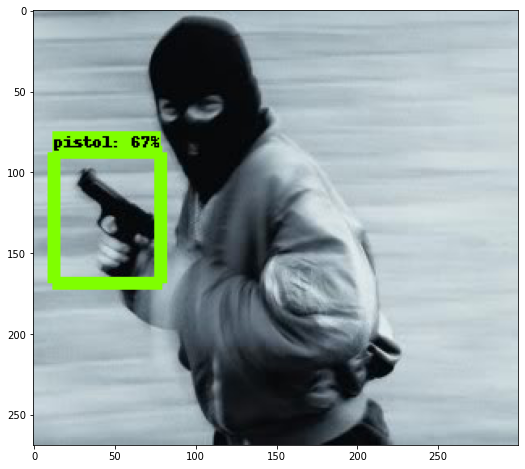

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1489).jpg


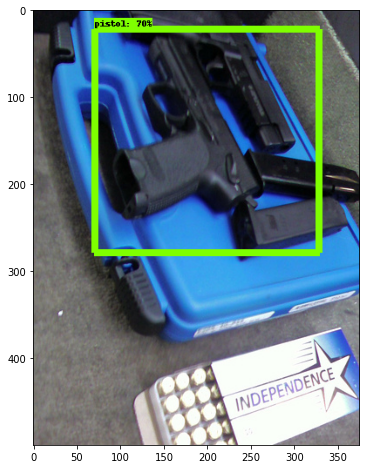

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1026).jpg


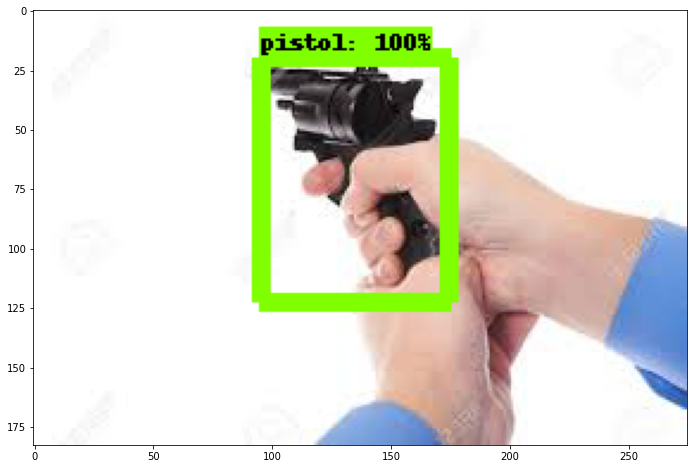

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1688).jpg


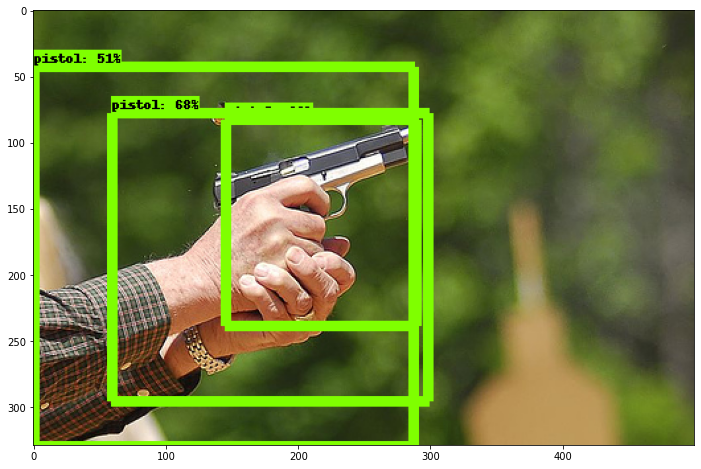

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1000).jpg


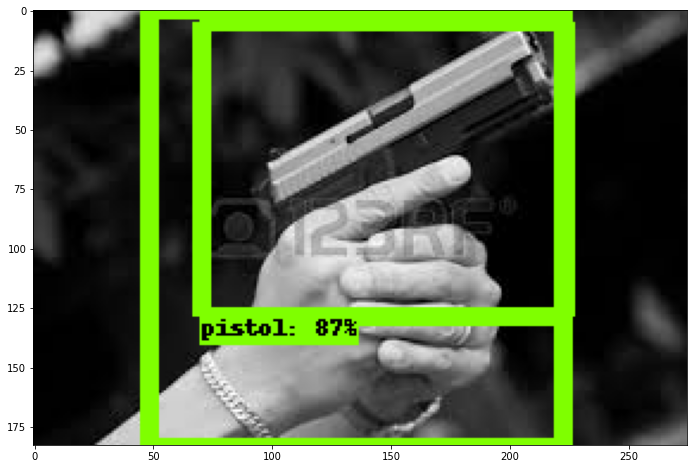

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1826).jpg


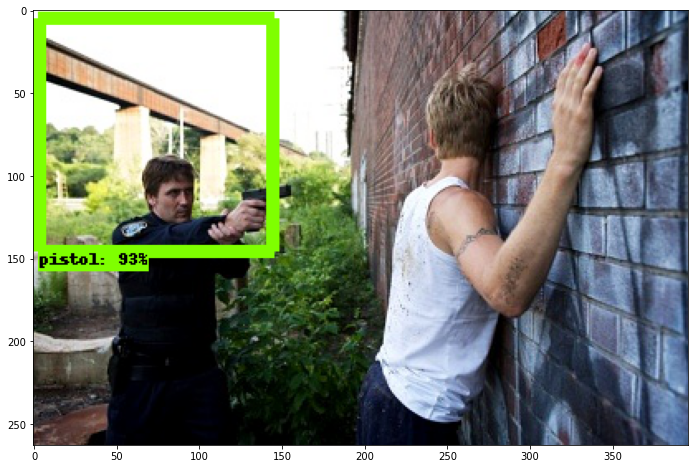

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1704).jpg


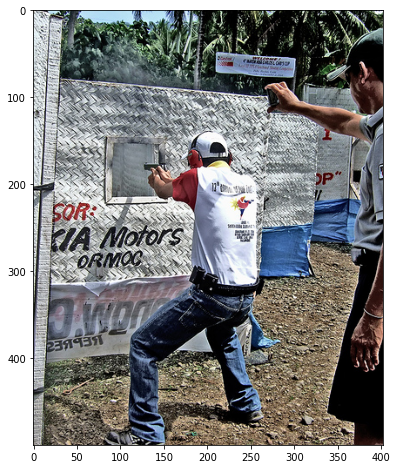

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1686).jpg


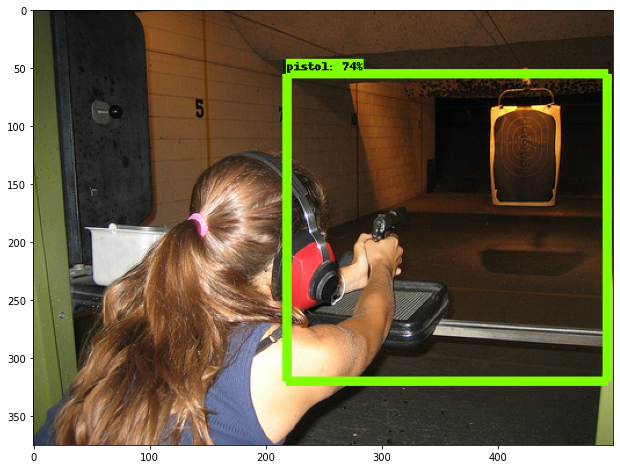

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1409).jpg


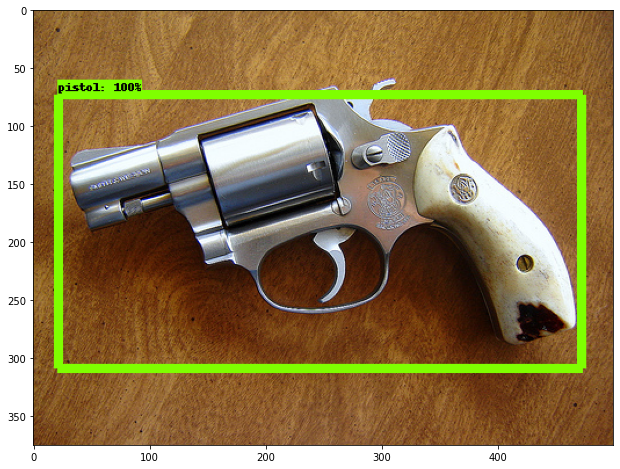

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1753).jpg


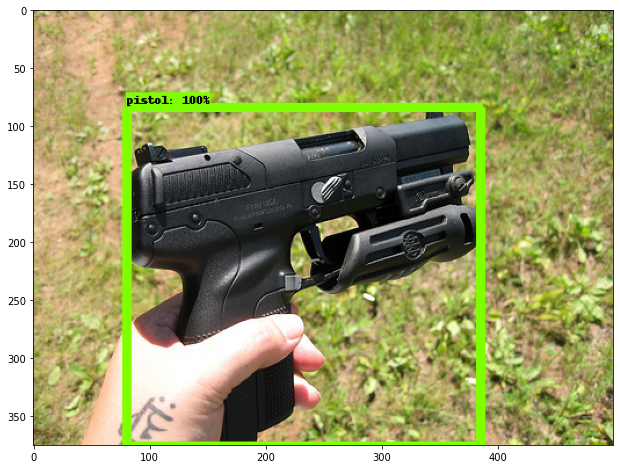

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (10).jpg


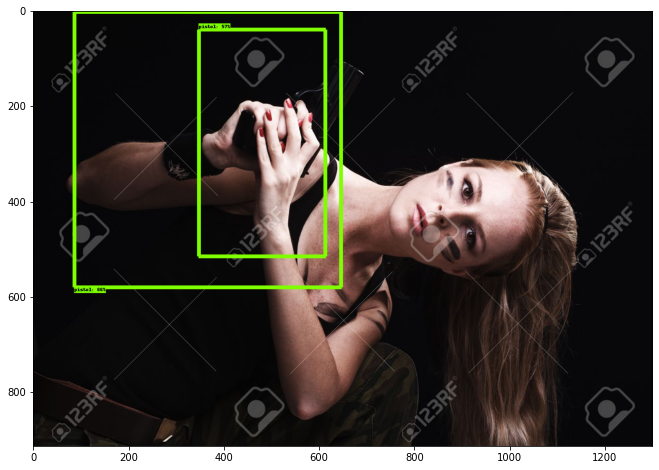

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1549).jpg


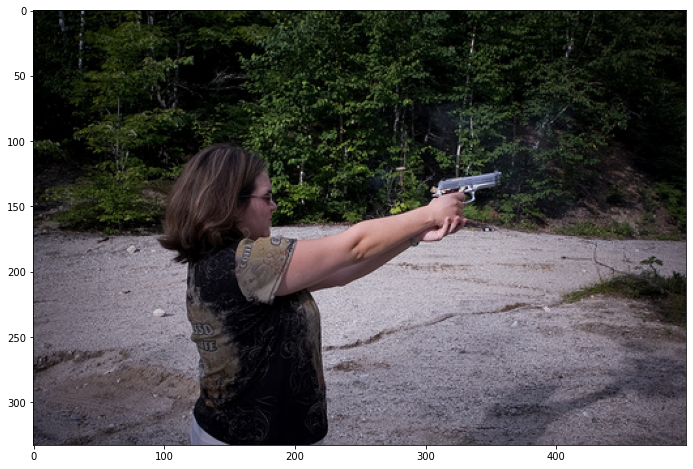

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1071).jpg


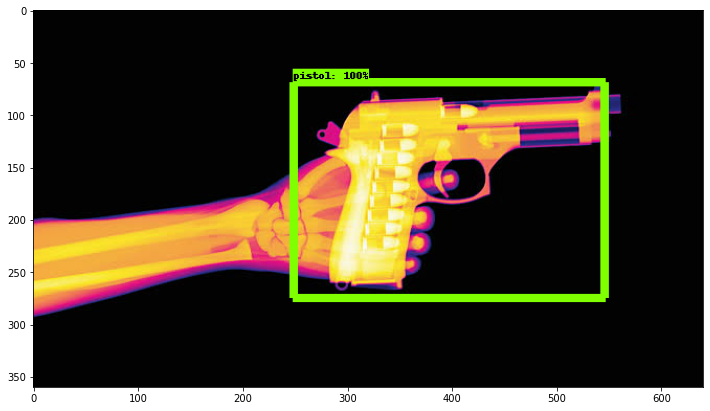

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1219).jpg


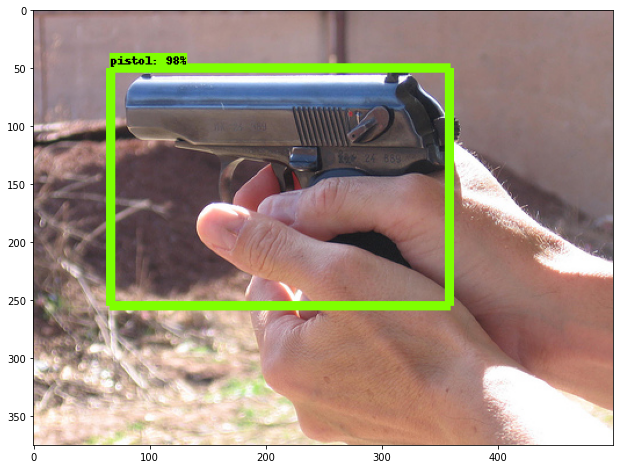

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1153).jpg


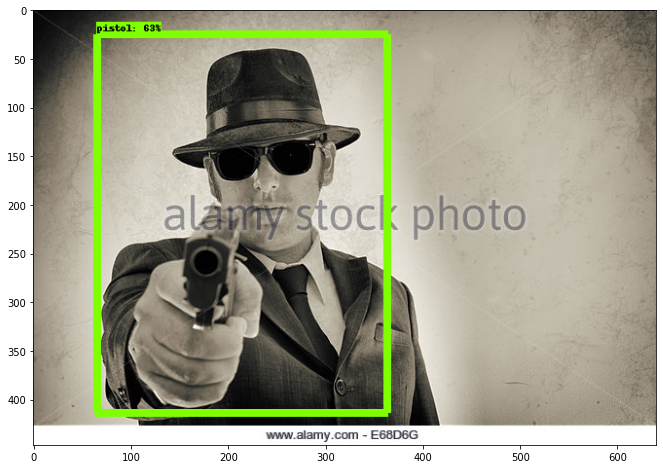

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1637).jpg


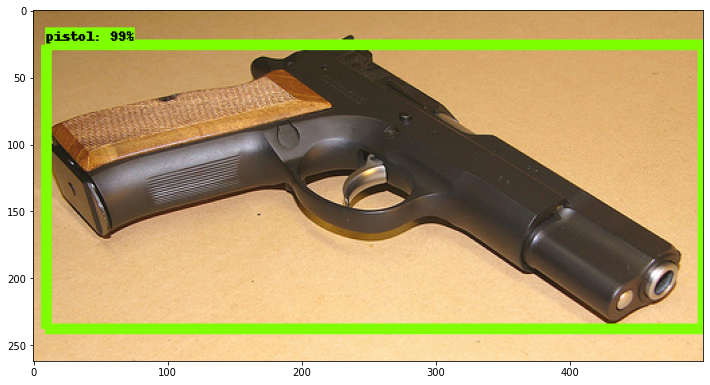

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1340).jpg


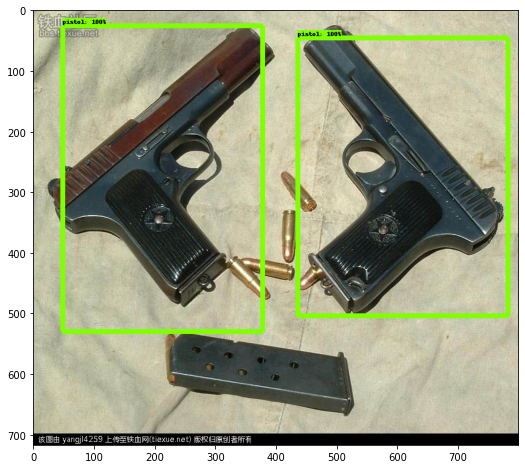

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1).jpg


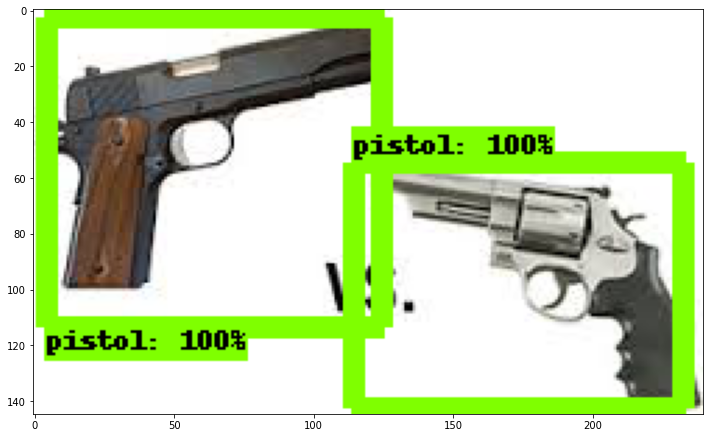

/content/tensorflow-object-detection-faster-rcnn/data/test/armas (1899).jpg


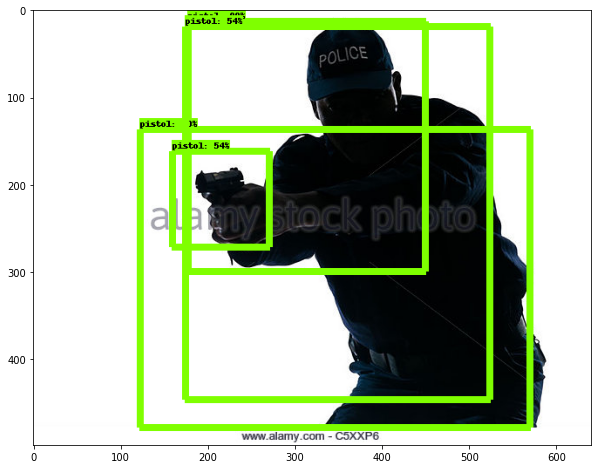

In [121]:
for image_path in TEST_IMAGE_PATHS:
  try:
    image = Image.open(image_path)
    print(image_path)
    # the array based representation of the image will be used later in order to prepare the
    # result image with boxes and labels on it.
    image_np = load_image_into_numpy_array(image)
    # Expand dimensions since the model expects images to have shape: [1, None, None, 3]
    image_np_expanded = np.expand_dims(image_np, axis=0)
    # Actual detection.
    output_dict = run_inference_for_single_image(image_np, detection_graph)
    # Visualization of the results of a detection.
    vis_util.visualize_boxes_and_labels_on_image_array(
        image_np,
        output_dict['detection_boxes'],
        output_dict['detection_classes'],
        output_dict['detection_scores'],
        category_index,
        instance_masks=output_dict.get('detection_masks'),
        use_normalized_coordinates=True,
        line_thickness=8)
    plt.figure(figsize=IMAGE_SIZE)
    plt.imshow(image_np)
    plt.show()
  except Exception:
    pass